

---

Arquitetura 0:

LSTM, 1 || Dropout 0.2 || Dense 1

* 1 Feature
* 50 epochs

---

Arquitetura 1:

LSTM, 64, l2=0.001 || Drop 0.3 || Batch Norm || LSTM, 32 || Drop 0.3 || Dense 1

* 2 Atributos, ROI e ROI_BTC
* Adam com learning rate 1e-4
* 200 epochs

---

Arquitetura 2:

CNN 15 || Pooling Layer 2 ||  LSTM 50 || Batch Norm || dropout 0.5 || Dense 128 || Batch Norm || Drop 0.2 || Dense 1

* 2 Atributos, ROI e ROI_BTC
* RMSProp, 1e-3
* 150 epochs

---

Arquitetura 3:

A construir


In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt
import math
import copy
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
from tensorflow.keras.layers import Input
from sklearn.preprocessing import StandardScaler
from keras.layers import Dropout

[*********************100%%**********************]  1 of 1 completed


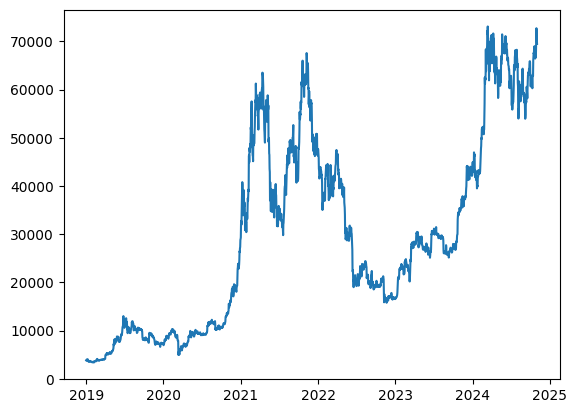

In [3]:
df = yf.download('BTC-USD', start='2019-01-01', end=pd.to_datetime("today").strftime("%Y-%m-%d"), interval='1d')
plt.plot(df['Close'])

In [ ]:
# HIPERPARÂMETROS:
start_date = '2014-08-21'
W = 200  # Lembrando que o tamanho do treinamento será W - w
w = 14  

In [3]:
# Criptomoedas que vamos escolher para nosso portifólio
cryptos = [
    'BTC-USD', 'LTC-USD'
]

In [4]:
## Função para calcular o retorno logarítmico
def log_return(series):
    return np.log(series['Close'] / series['Open'])

In [5]:
data = {}
for crypto in cryptos:
    # Baixar dados e calcular retorno logarítmico
    df = yf.download(crypto, start=start_date, end=pd.to_datetime("today").strftime("%Y-%m-%d"), interval='1d')
    df['Return'] = log_return(df)

    # Construir DataFrame final, pegando o retorno do dia anterior e o atual
    df_final = pd.DataFrame({
        #'Volume': df['Volume'],
        'Crypto_Return_Today': df['Return']
    }).dropna()

    data[crypto] = df_final

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
aux = yf.download('BTC-USD', start=start_date, end=pd.to_datetime("today").strftime("%Y-%m-%d"), interval='1d')
aux['Return'] = log_return(aux)
aux = pd.DataFrame({'BTC-Return': aux['Return']})

data['LTC-USD'] = pd.merge(aux, data['LTC-USD'],  left_index=True, right_index=True, how='outer').dropna()

aux = yf.download('LTC-USD', start=start_date, end=pd.to_datetime("today").strftime("%Y-%m-%d"), interval='1d')
aux['Return'] = log_return(aux)
aux = pd.DataFrame({'LTC-Return': aux['Return']})

data['BTC-USD'] = pd.merge(aux, data['BTC-USD'],  left_index=True, right_index=True, how='outer').dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
data['LTC-USD']

,BTC-Return,Crypto_Return_Today
Date,,
2014-09-17 00:00:00+00:00,-0.018480,-0.005390
2014-09-18 00:00:00+00:00,-0.073606,-0.078024
2014-09-19 00:00:00+00:00,-0.071607,-0.079802
2014-09-20 00:00:00+00:00,0.035423,-0.009926
2014-09-21 00:00:00+00:00,-0.022963,-0.004031
...,...,...
2024-10-25 00:00:00+00:00,-0.022594,-0.034909
2024-10-26 00:00:00+00:00,0.005776,-0.003608
2024-10-27 00:00:00+00:00,0.013424,0.038447


In [8]:
data_complete = {}
for crypto in cryptos:
    # Baixar dados e calcular retorno logarítmico
    df = yf.download(crypto, start=start_date, end=pd.to_datetime("today").strftime("%Y-%m-%d"), interval='1d')
    df['Return'] = log_return(df)

    # Construir DataFrame final, pegando o retorno do dia anterior e o atual
    df_final = pd.DataFrame({
        #'Volume': df['Volume'],
        'Crypto_Return_Today': df['Return']
    }).dropna()

    # Adicionar a coluna 'exp_value' com valores NaN
    df_final['exp_value'] = np.nan

    # Armazenar no dicionário
    data_complete[crypto] = df_final

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
print(len(data_complete['LTC-USD']))
data_complete['LTC-USD']

3696


,Crypto_Return_Today,exp_value
Date,,
2014-09-17 00:00:00+00:00,-0.005390,NaN
2014-09-18 00:00:00+00:00,-0.078024,NaN
2014-09-19 00:00:00+00:00,-0.079802,NaN
2014-09-20 00:00:00+00:00,-0.009926,NaN
2014-09-21 00:00:00+00:00,-0.004031,NaN
...,...,...
2024-10-25 00:00:00+00:00,-0.034909,NaN
2024-10-26 00:00:00+00:00,-0.003608,NaN
2024-10-27 00:00:00+00:00,0.038447,NaN


In [10]:
# Criando a função First Transformation, que recebe uma tabela contendo os retornos de todos os dias dos ultimos X anos e retorno um vetor, que cada elemento
# é uma tabela do retorno de W+1 dias.
def FirstTransform(df, W):
    vet = []
    Linhas, Colunas = df.shape
    for i in range(Linhas, W+1, -1):
        vet.append(df.iloc[(i-W-1):i])
    return vet

In [11]:
# Aqui eu perco W+1 dias do meu dataset
for crypto in cryptos:
    data[crypto] = FirstTransform(data[crypto], W)

In [12]:
print(len(data['LTC-USD']))
data['LTC-USD'][0]

3495


,BTC-Return,Crypto_Return_Today
Date,,
2024-04-12 00:00:00+00:00,-0.041760,-0.134492
2024-04-13 00:00:00+00:00,-0.051411,-0.105760
2024-04-14 00:00:00+00:00,0.029367,0.029420
2024-04-15 00:00:00+00:00,-0.035825,-0.023326
2024-04-16 00:00:00+00:00,0.006171,0.023415
...,...,...
2024-10-25 00:00:00+00:00,-0.022594,-0.034909
2024-10-26 00:00:00+00:00,0.005776,-0.003608
2024-10-27 00:00:00+00:00,0.013424,0.038447


## 2.2 Separar em treinamento e teste - Permitir Bagging

In [13]:
test_target = {}
for crypto in cryptos:
    row = []
    for i in range(len(data[crypto])):
        row.append((pd.DataFrame(data[crypto][i].iloc[-1])).T)
        data[crypto][i] = data[crypto][i].drop(data[crypto][i].index[-1])
    test_target[crypto] = row

In [14]:
data['LTC-USD'][0], test_target['LTC-USD'][0]['Crypto_Return_Today']

(                           BTC-Return  Crypto_Return_Today
 Date                                                      
 2024-04-12 00:00:00+00:00   -0.041760            -0.134492
 2024-04-13 00:00:00+00:00   -0.051411            -0.105760
 2024-04-14 00:00:00+00:00    0.029367             0.029420
 2024-04-15 00:00:00+00:00   -0.035825            -0.023326
 2024-04-16 00:00:00+00:00    0.006171             0.023415
 ...                               ...                  ...
 2024-10-24 00:00:00+00:00    0.022363             0.014806
 2024-10-25 00:00:00+00:00   -0.022594            -0.034909
 2024-10-26 00:00:00+00:00    0.005776            -0.003608
 2024-10-27 00:00:00+00:00    0.013424             0.038447
 2024-10-28 00:00:00+00:00    0.028807            -0.005068
 
 [200 rows x 2 columns],
 2024-10-29 00:00:00+00:00    0.045062
 Name: Crypto_Return_Today, dtype: float64)

## 2.3 Bagging

In [15]:
# Definindo uma função bagging, que recebe um dataframe e retorna um vetor de dataframes.
def Bagging(df, n, gamma):
    df_bagged = []
    for i in range(gamma):
        aux = df.sample(n = n, random_state = i)
        aux = aux.sort_index()
        df_bagged.append(aux)
    return df_bagged

# 3. Machine Learning

* vamos peimeiro fazer do modo 1 para todos os dias
* depois aplicar para os ultimos 290 dias o modo 2 (contém bagging e purge K-Fold-CV)

## 3.1 Função do Modelo


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
# Arquitetura 1 e 2:
def create_model(a, b):
    model = Sequential([
        Input(shape=(a, b)),
        LSTM(units=64, return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        BatchNormalization(),
        LSTM(units=32, return_sequences=False),
        Dropout(0.3),
        Dense(units=1)
    ])
    optimizer = RMSprop(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


In [17]:
# Função do modelo LSTM
def Model(df, time_step, features, model=None):
    # Normalizando o dataframe
    #scaler = StandardScaler()
    #df_scaled = scaler.fit_transform(df)
    #df_array = np.array(df_scaled)
    df_array = np.array(df)

    # Transformando no formato LSTM
    X_lstm = []
    y_lstm = []
    for i in range(time_step, len(df_array)):
        X_lstm.append(df_array[i-time_step:i, :])  # Pega 'timesteps' linhas anteriores
        y_lstm.append(df_array[i])  # Alvo é o valor do dia seguinte
    X_lstm = np.array(X_lstm)
    y_lstm = np.array(y_lstm)

    # Separar o X_train (todos exceto o último elemento)
    X_train = X_lstm[:-1]
    y_train = y_lstm[:-1]
    y_train = pd.DataFrame(y_train)[features - 1].to_numpy()
    y_train = y_train.reshape((len(y_train), 1))
    y_train.shape

    # X_test e y_test
    X_test = X_lstm[-1:]
    y_test = y_lstm[-1:]
    y_test = y_lstm[-1:]
    y_test = pd.DataFrame(y_test)[features - 1].to_numpy()
    y_test = y_test.reshape((len(y_test), 1))

    # Treinar o modelo específico para a criptomoeda

    # Arquitetura 1:
    #reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6, verbose=0)
    #model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0, callbacks=[reduce_lr])


    # Arquitetura 2:
    model.fit(X_train, y_train, epochs=200, verbose=0)
    # Fazer a previsão
    y_hat_scaled = model.predict(X_test)


    return y_hat_scaled

##  3.2 Treinamento com Paralelismo e Geração dos Expected Values

In [18]:
def Add(y_hat, data_complete, ind, crypto):
    data_complete[crypto].at[ind, 'exp_value'] = y_hat

In [19]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Usando GPU:", physical_devices[0])
else:
    print("Usando CPU")

Usando GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [20]:
for crypto in cryptos:
    print(len(data[crypto]))
len(data['LTC-USD'][0])

3495
3495


200

In [21]:
test_target['LTC-USD'][2550]
test_target['LTC-USD'][2250]

,BTC-Return,Crypto_Return_Today
2018-09-01 00:00:00+00:00,0.020852,0.065999


In [ ]:
# Função que processa cada criptomoeda (paralelismo será aplicado aqui)
def process_crypto(crypto, data, test_target, data_complete, time_step, features):
    # Criar um modelo para cada criptomoeda
    for day in range(2250, 2350):
        model = create_model(time_step, features)

        df_train = data[crypto][day].copy()  # df é uma tabela de 300 linhas e uma coluna
        df_test = test_target[crypto][day].copy()  # df_test é uma tabela com 1 linha e uma coluna
        df = pd.concat([df_train, df_test], ignore_index=True)  # Unindo as duas tabelas

        scaler = StandardScaler()
        df = scaler.fit_transform(df)

        y_hat_scaled = Model(df, time_step, features, model=model)  # Chamar o modelo para previsão

        y_hat_scaled = np.repeat(y_hat_scaled, features, axis=1)
        y_hat_scaled = pd.DataFrame(y_hat_scaled, columns=(['Predictions_1'], ['Predictions_2']))

        y_hat = scaler.inverse_transform(y_hat_scaled)[0][features - 1]

        Add(y_hat, data_complete, df_test.index[0], crypto)  # Adicionar o resultado na tabela final

    print("\nMoeda: ", crypto, " processada")

# Número de samples que vamos testar o modelo
time_step = w
features = 2

# Criar o executor para rodar as criptomoedas em paralelo
with ThreadPoolExecutor() as executor:
    # Executar o processo para cada criptomoeda simultaneamente
    futures = [
        executor.submit(process_crypto, crypto, data, test_target, data_complete, time_step, features)
        for crypto in cryptos
    ]

    # Aguardar a conclusão de todas as threads
    for future in futures:
        future.result()

print("Processamento em paralelo finalizado.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

3min para

In [1]:
df = data_complete['BTC-USD']
df.dropna()

NameError: name 'data_complete' is not defined

In [22]:
data_visual = {}
for crypto in cryptos:
    data_visual[crypto] = pd.read_csv(f"{crypto}.csv", index_col='Date')
    data_visual[crypto] = data_visual[crypto][~data_visual[crypto].index.duplicated(keep='first')]

In [62]:
data_visual = data_complete

In [64]:
for crypto in cryptos:
    df = data_visual[crypto]
    df['ae'] = df['exp_value'] - df['Crypto_Return_Today']
    df['ae'] = abs(df['ae'])
    df = df.dropna()
    num_positive = (df['Crypto_Return_Today'] > 0).sum()
    num_negative = (df['Crypto_Return_Today'] < 0).sum()

    hat_pos = (df['exp_value'] > 0).sum()
    hat_neg = (df['exp_value'] < 0).sum()


    TP = ((df['Crypto_Return_Today'] > 0)  & (df['exp_value'] > 0)).sum()
    TN = ((df['Crypto_Return_Today'] < 0)  & (df['exp_value'] < 0)).sum()
    FP = ((df['Crypto_Return_Today'] < 0)  & (df['exp_value'] > 0)).sum()
    FN = ((df['Crypto_Return_Today'] > 0)  & (df['exp_value'] < 0)).sum()

    #rmse = np.sqrt(((df['Crypto_Return_Today'] - df['exp_value']) ** 2).mean())
    print("\n\n--------------------------------------------------------")
    print("\n\nCriptomoeda: ", crypto)
    print("\n                              Real")
    print("\nNumero de Subidas: ",num_positive,"   |   ",100*num_positive / (num_negative + num_positive),"%")
    print("\nNumero de Quedas : ",num_negative,"   |   ",100*num_negative / (num_negative + num_positive),"%")

    print("\n                              Predito")
    print("\nNumero de Subidas: ",hat_pos,"   |   ", 100*hat_pos / (hat_neg + hat_pos),"%")
    print("\nNumero de Quedas : ",hat_neg,"   |   ", 100*hat_neg / (hat_neg + hat_pos),"%")

    print("\nMean Absolute Error MAE: ", df['ae'].mean())
    #print("\nRoot Mean Squared Error RMSE: ", rmse)
    print("\nAcc: ", (TP+TN) / (TP + FP + FN + FP))
    print("\nSen: ", (TP) / (TP + FN)) # significa, entre os que subiram, quantos % eu consegui identificar que realmente subiu
    print("\nSpe: ", (TP) / (TP + FN)) # significa, entre os que cairam, quantos % eu consegui identificar que realmente caiu
    print("\nPre: ", (TP) / (TP + FP)) # significa, entre os que eu disse que ia subir, quantos % realmente subiram

    TP = ((df['Crypto_Return_Today'] > 0)  & (df['exp_value'] > 0) & (df['exp_value'] >= 0.0002)).sum()
    FP = (((df['Crypto_Return_Today'] < 0)  & (df['exp_value'] > 0)) & (df['exp_value'] >= 0.0002)).sum()

    limite_90 = df['exp_value'].quantile(0.9)
    menor_valor_10_maiores = df[df['exp_value'] >= limite_90]['exp_value'].min()
    print("\nLower bound dos 10% maiores: ", menor_valor_10_maiores)

    print("\nPrecisao para maiores que 0.008: ", (TP) / (TP + FP)) # significa, entre os que eu disse que ia subir, quantos % realmente subiram



--------------------------------------------------------


Criptomoeda:  BTC-USD

                              Real

Numero de Subidas:  57    |    57.0 %

Numero de Quedas :  43    |    43.0 %

                              Predito

Numero de Subidas:  7    |    7.0 %

Numero de Quedas :  93    |    93.0 %

Mean Absolute Error MAE:  0.025410940354433153

Acc:  0.6461538461538462

Sen:  0.05263157894736842

Spe:  0.05263157894736842

Pre:  0.42857142857142855

Lower bound dos 10% maiores:  -0.0006438298150897026

Precisao para maiores que 0.008:  0.42857142857142855


--------------------------------------------------------


Criptomoeda:  LTC-USD

                              Real

Numero de Subidas:  41    |    41.0 %

Numero de Quedas :  59    |    59.0 %

                              Predito

Numero de Subidas:  7    |    7.0 %

Numero de Quedas :  93    |    93.0 %

Mean Absolute Error MAE:  0.033926081099572285

Acc:  1.183673469387755

Sen:  0.07317073170731707

Spe:  0.073

In [ ]:
df = data_visual['BTC-USD']
df['ae'] = df['exp_value'] - df['Crypto_Return_Today']
df['ae'] = abs(df['ae'])
df['mae'] = df['ae'].rolling(window = 50).mean()

In [ ]:
for crypto in cryptos:
    data_complete[crypto]= data_complete[crypto][~data_complete[crypto].index.duplicated(keep='first')]

In [ ]:
data_complete['ETH-USD'].dropna()

In [ ]:
data_aux = {}
for crypto in cryptos:
    data_aux[crypto] = pd.read_csv(f"{crypto}.csv", index_col='Date')
    #data_complete[crypto] = pd.read_csv(f"{crypto}.csv")

In [ ]:
data_aux['ETH-USD'].dropna()

In [ ]:
data_aux['ETH-USD'][-542:].head(10)
#data_complete['ETH-USD'][:-550]

In [ ]:
for crypto in cryptos:
    df_aux = data_complete[crypto]
    df_aux = pd.concat([df_aux[:-550], data_aux[crypto][-542:]])
    df_aux.index = pd.to_datetime(df_aux.index)
    data_complete[crypto] = df_aux


In [ ]:
for crypto in cryptos:
    data_complete[crypto]= data_complete[crypto][~data_complete[crypto].index.duplicated(keep='first')]

In [ ]:
data_complete['ETH-USD'].dropna()

In [ ]:
for crypto in cryptos:
    # Define o nome do arquivo como o nome da criptomoeda seguido de .csv
    filename = f"{crypto}.csv"

    # Salva o DataFrame data_complete[crypto] no arquivo .csv
    data_complete[crypto].to_csv(filename, index=True)

    print(f"Arquivo {filename} salvo com sucesso!")

Arquivo BTC-USD.csv salvo com sucesso!
Arquivo LTC-USD.csv salvo com sucesso!


gerar uns graficos aqui

## 3.3 Método 2 para os ultimos X intervalos

* Aplicar bagging
* Aplicar CV e Otimização de HP
* Fazer treinamento para uma janela W maior de tempo

In [ ]:
# for day in data[crypto]:
#       day = bagging(day)

# for day in data[crypto]:
#       for sample in day:
#               sample = CV(sample) # transforma sample em um vetor de folds. Ultimos 10% do fold são validation e 90% são pure train

# for day in data[crypto]:
#       for sample in day:
#               for fold in sample:
#                       y_hat = model(fold)
#               y_hat_mean = y_hat / len(sample)
#       y_hat_mean_mean = y_hat_mean / len(day)